# **Waze User Churn Project**


## Machine Learning Techniques



**The purpose** of this model is to find factors that drive user churn.

**The goal** of this model is to predict whether or not a Waze user is retained or churned.
<br/>

**Overview:**
1. Imports & Data Loading
2. Feature Engineering
3. Data Prep
4. Modeling
5. Results & Evaluation

### 1. Imports & Data Loading


In [119]:
# Packages for data manipulation
import numpy as np
import pandas as pd

# Packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("bright")
sns.set_style("darkgrid")
sns.set_context("notebook")

# Allows all columns to be displayed
pd.set_option('display.max_columns', None)

# Packages for data modeling
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import  train_test_split, GridSearchCV, PredefinedSplit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Packages for Calculating Metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Package to plot feature importance
from xgboost import plot_importance

# Package to save Model
import pickle as pkl

In [2]:
print(np.__version__ , pd.__version__)

1.24.3 2.1.1


In [3]:
from platform import python_version

print(python_version())

3.9.0


In [5]:
# Import dataset
df0 = pd.read_csv('../waze_dataset.csv')

In [6]:
# Inspect the first five rows
df0.head()

ID     label  sessions  drives  total_sessions  n_days_after_onboarding  \
0   0  retained       283     226      296.748273                     2276   
1   1  retained       133     107      326.896596                     1225   
2   2  retained       114      95      135.522926                     2651   
3   3  retained        49      40       67.589221                       15   
4   4  retained        84      68      168.247020                     1562   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   
3                     322                       7        913.591123   
4                     166                       5       3950.202008   

   duration_minutes_drives  activity_days  driving_days   device  
0              1985.775061             28            19  Android  
1              3160.472914             13            11   iPhone  
2              1610.735904             14             8  Android  
3               587.196542              7             3   iPhone  
4              1219.555924             27            18  Android

### 2. Feature engineering

A lot of this was done in EDA notebook.

In [7]:
# Copy the df0 dataframe before feature engineering
df = df0.copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### **`km_per_driving_day`**

The mean number of km driven on each driving day in the last month.

In [9]:
# Creating `km_per_driving_day` feature
df["km_per_driving_day"] = df["driven_km_drives"]/df["driving_days"]

# descriptive stats
df["km_per_driving_day"].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [16]:
# Converting infinite values to zero
df["km_per_driving_day"] = df["km_per_driving_day"].replace({np.inf: 0})

# Confirming it worked
df[df["driving_days"] == 0].head()

ID     label  sessions  drives  total_sessions  n_days_after_onboarding  \
13  13  retained        80      64      132.830506                     3154   
14  14   churned        72      66      401.351809                     2524   
56  56   churned       150     127      187.708346                     2028   
64  64  retained         4       3      113.818787                     1830   
81  81   churned        26      23       83.166886                     2118   

    total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
13                      39                      16       8531.248070   
14                      54                      24       5922.811202   
56                     208                     132       1396.461977   
64                     233                       0       9624.439528   
81                     335                       0        944.204641   

    duration_minutes_drives  activity_days  driving_days   device  \
13              6324.273457              1             0  Android   
14              2227.280393              0             0  Android   
56               496.620891              0             0   iPhone   
64              3213.049582              6             0  Android   
81               455.026306              2             0  Android   

    km_per_driving_day  percent_sessions_in_last_month  professional_driver  \
13                 0.0                        0.602271                    0   
14                 0.0                        0.179394                    0   
56                 0.0                        0.799112                    0   
64                 0.0                        0.035144                    0   
81                 0.0                        0.312624                    0   

    total_sessions_per_day  
13                0.042115  
14                0.159014  
56                0.092558  
64                0.062196  
81                0.039267

#### **`percent_sessions_in_last_month`**

The % of each user's total sessions that were done in the last month.


In [11]:
# Creating `percent_sessions_in_last_month` feature
df["percent_sessions_in_last_month"] = df["sessions"] / df["total_sessions"]

# descriptive stats
df["percent_sessions_in_last_month"].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**

A binary feature that is 
- 1 -> for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.
- 0 -> otherwise

In [12]:
# Creating `professional_driver` feature
df["professional_driver"] = np.where(((df["drives"] >= 60) & (df["driving_days"] >= 15)), 1, 0)

In [13]:
print(df["professional_driver"].value_counts())

professional_driver
0    12405
1     2594
Name: count, dtype: int64


#### **`total_sessions_per_day`**

The avg # of sessions per day since joining.

In [14]:
# Creating `total_sessions_per_day` feature
df["total_sessions_per_day"] = df["total_sessions"] / df["n_days_after_onboarding"]

As with other features, get descriptive statistics for this new feature.

In [15]:
# descriptive stats
df["total_sessions_per_day"].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

The avg KM per hour driven in the last month.

In [17]:
# Create `km_per_hour` feature
df["km_per_hour"] = df["driven_km_drives"] / (df["duration_minutes_drives"]/60)
df["km_per_hour"].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

#### **`km_per_drive`**

The avg # of KM per drive made in the last month.

In [18]:
# Creating `km_per_drive` feature
df["km_per_drive"] = df["driven_km_drives"] / df["drives"]
df["km_per_drive"].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [20]:
# Converting infinite values to 0
df["km_per_drive"] = df["km_per_drive"].replace({np.inf: 0})

# Confirming it worked
df["km_per_drive"].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

The % of total sessions that were used to navigate to one of the users' favorite places.

This could be useful info to check if the following assumptions is true:
> Users who drive more to unfamiliar places (ie. non-favourite places) are less likely to churn.
> ie. they need more help navigating.


In [21]:
# Creating `percent_of_sessions_to_favorite` feature
df["percent_of_sessions_to_favorite"] = (df["total_navigations_fav1"] + df["total_navigations_fav2"]) / df["total_sessions"]

# descriptive stats
df["percent_of_sessions_to_favorite"].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

### 3. Data Prep


#### Drop Nulls

In [22]:
# Drop rows with missing values
df = df.dropna(axis=0)

In [24]:
df.isna().sum().sum()

0

#### Check Outliers



From the EDA Notebook we know many of the features have outliers.  
But, we don't need imputation since tree-based models are resilient to outliers.

#### Variable Encoding

##### **Device**

* `Android` -> `0`
* `iPhone` -> `1`

In [25]:
# Creating new `device2` variable
df["device2"] = np.where((df["device"] == "iPhone"), 1, 0)

In [26]:
df.head(3)

ID     label  sessions  drives  total_sessions  n_days_after_onboarding  \
0   0  retained       283     226      296.748273                     2276   
1   1  retained       133     107      326.896596                     1225   
2   2  retained       114      95      135.522926                     2651   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   

   duration_minutes_drives  activity_days  driving_days   device  \
0              1985.775061             28            19  Android   
1              3160.472914             13            11   iPhone   
2              1610.735904             14             8  Android   

   km_per_driving_day  percent_sessions_in_last_month  professional_driver  \
0          138.360267                        0.953670                    1   
1         1246.901868                        0.406856                    0   
2          382.393602                        0.841186                    0   

   total_sessions_per_day  km_per_hour  km_per_drive  \
0                0.130381    79.430298     11.632058   
1                0.266854   260.389902    128.186173   
2                0.051121   113.953460     32.201567   

   percent_of_sessions_to_favorite  device2  
0                         0.700931        0  
1                         0.253903        1  
2                         0.000000        0

##### **Target**

- `retained` -> `0`
- `churned` -> `1`


In [27]:
# Creating binary `label2` column
df["label2"] = np.where((df["label"] == "churned"), 1, 0)

In [28]:
df.head(3)

ID     label  sessions  drives  total_sessions  n_days_after_onboarding  \
0   0  retained       283     226      296.748273                     2276   
1   1  retained       133     107      326.896596                     1225   
2   2  retained       114      95      135.522926                     2651   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   

   duration_minutes_drives  activity_days  driving_days   device  \
0              1985.775061             28            19  Android   
1              3160.472914             13            11   iPhone   
2              1610.735904             14             8  Android   

   km_per_driving_day  percent_sessions_in_last_month  professional_driver  \
0          138.360267                        0.953670                    1   
1         1246.901868                        0.406856                    0   
2          382.393602                        0.841186                    0   

   total_sessions_per_day  km_per_hour  km_per_drive  \
0                0.130381    79.430298     11.632058   
1                0.266854   260.389902    128.186173   
2                0.051121   113.953460     32.201567   

   percent_of_sessions_to_favorite  device2  label2  
0                         0.700931        0       0  
1                         0.253903        1       0  
2                         0.000000        0       0

#### Feature Selection

Tree-based models can handle multicollinearity, so there is no need to drop features as done previously.

We will drop `ID` since it doesn't inform churn and `device` since it is the categorical version of `device2`.

In [29]:
# Drop `ID` column
df = df.drop(columns=["ID"])
df.head(3)

label  sessions  drives  total_sessions  n_days_after_onboarding  \
0  retained       283     226      296.748273                     2276   
1  retained       133     107      326.896596                     1225   
2  retained       114      95      135.522926                     2651   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   

   duration_minutes_drives  activity_days  driving_days   device  \
0              1985.775061             28            19  Android   
1              3160.472914             13            11   iPhone   
2              1610.735904             14             8  Android   

   km_per_driving_day  percent_sessions_in_last_month  professional_driver  \
0          138.360267                        0.953670                    1   
1         1246.901868                        0.406856                    0   
2          382.393602                        0.841186                    0   

   total_sessions_per_day  km_per_hour  km_per_drive  \
0                0.130381    79.430298     11.632058   
1                0.266854   260.389902    128.186173   
2                0.051121   113.953460     32.201567   

   percent_of_sessions_to_favorite  device2  label2  
0                         0.700931        0       0  
1                         0.253903        1       0  
2                         0.000000        0       0

#### Class Imbalance

`17.7%` users `churned` vs. `82.3%` were `retained`.

In [31]:
# Get class balance of 'label' col
df["label"].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

#### Metric Selection



A model can have high accuracy on an imbalanced dataset and fail to predict the minority class, which, in this case, is more important than the majority class. Thus, **RECALL** would be the best metric to _minimize_ **false positive** predictions.

#### Data Splitting


Split the data into train/validation/test sets (60/20/20)

In [38]:
# 1. Isolating X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolating y variable
y = df["label2"]

# 3. Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

# 4. Splitting into train and validate sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, train_size=0.75, stratify=y_train, random_state=42)

Verifing # of samples in datasets.

In [39]:
print("Training Size: ", len(X_train))
print("Tr Size: ", len(X_tr))
print("Val Size: ", len(X_val))
print("Testing Size: ", len(X_test))

Training Size:  11439
Tr Size:  8579
Val Size:  2860
Testing Size:  2860


In [42]:
split_index = [0 if x in X_val.index else -1 for x in X_train.index]
custom_split = PredefinedSplit(split_index)

### 4. Modeling

#### Training

##### **Random Forest**

Best Testing Scores: 			
- **Acc**: `0.8186`
- **Precision**: `0.4617`
- **Recall**: `0.1355`
- **F1**: `0.2092`

In [47]:
# 1. Instantiating the RF classifier
rf = RandomForestClassifier(random_state=42)

# 2. Creating a dict of hyperparameters to tune
cv_params = {'n_estimators': [20, 50, 100, 300], 
             'max_depth': [None, 5, 10, 15, 20, 50], 
             'min_samples_leaf': [2, 3, 5, 10, 15, 50], 
             'min_samples_split': [0.001, 0.01], 
             'max_features': ["sqrt"],
             'max_samples': [0.25, 0.5, 0.75, 0.9]}


# 3. Defining a dict of scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiating the GridSearchCV object
rf_gscv = GridSearchCV(rf, param_grid=cv_params, cv=5, scoring=scoring, refit='recall', n_jobs=-1, verbose=2)

RF Model Fitting

In [48]:
%%time

rf_gscv.fit(X_train, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-pack

[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=2, min_samples_split=0.001, n_estimators=20; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=2, min_samples_split=0.001, n_estimators=300; total time=   4.0s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=3, min_samples_split=0.01, n_estimators=20; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=3, min_samples_split=0.01, n_estimators=20; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=3, min_samples_split=0.01, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=3, min_samples_split=0.01, n_estimators=300; total time=   3.2s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=5, min_samples_split=0.01, n_estimators=100; total time=   1.4s
[

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-pack

[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=2, min_samples_split=0.001, n_estimators=20; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=2, min_samples_split=0.001, n_estimators=300; total time=   4.1s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=3, min_samples_split=0.01, n_estimators=20; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=3, min_samples_split=0.01, n_estimators=20; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=3, min_samples_split=0.01, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=5, min_samples_split=0.001, n_estimators=20; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=5, min_samples_split=0.001, n_estimators=50; total time=   0.6s


/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-pack

[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=2, min_samples_split=0.001, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=2, min_samples_split=0.01, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=2, min_samples_split=0.01, n_estimators=300; total time=   3.2s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=3, min_samples_split=0.01, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=5, min_samples_split=0.001, n_estimators=20; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=5, min_samples_split=0.001, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.25, min_samples_leaf=5, min_samples_split=0.001, n_estimators=300; total time=   4.4s

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-pack


[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=2, min_samples_split=0.001, n_estimators=300; total time=  11.0s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=3, min_samples_split=0.001, n_estimators=300; total time=  10.5s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=5, min_samples_split=0.001, n_estimators=300; total time=  10.0s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=10, min_samples_split=0.001, n_estimators=300; total time=   9.2s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=15, min_samples_split=0.001, n_estimators=300; total time=   8.6s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=50, min_samples_split=0.001, n_estimators=300; total time=   6.7s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.25, min_samples_leaf=2, min_samples_split=0.01, n_estimators=50; total time=   0.4s

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-pack


[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=3, min_samples_split=0.01, n_estimators=300; total time=   9.8s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=5, min_samples_split=0.01, n_estimators=100; total time=   2.8s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=10, min_samples_split=0.001, n_estimators=50; total time=   1.8s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=10, min_samples_split=0.001, n_estimators=100; total time=   3.5s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=10, min_samples_split=0.01, n_estimators=20; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=10, min_samples_split=0.01, n_estimators=50; total time=   1.4s
[CV] END max_depth=None, max_features=sqrt, max_samples=0.9, min_samples_leaf=10, min_samples_split=0.01, n_estimators=300; total time=   9.4s
[

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-pack


[CV] END max_depth=5, max_features=sqrt, max_samples=0.9, min_samples_leaf=50, min_samples_split=0.01, n_estimators=20; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.9, min_samples_leaf=50, min_samples_split=0.01, n_estimators=20; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.9, min_samples_leaf=50, min_samples_split=0.01, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.9, min_samples_leaf=50, min_samples_split=0.01, n_estimators=300; total time=   4.7s
[CV] END max_depth=10, max_features=sqrt, max_samples=0.25, min_samples_leaf=3, min_samples_split=0.001, n_estimators=50; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, max_samples=0.25, min_samples_leaf=3, min_samples_split=0.001, n_estimators=300; total time=   3.5s
[CV] END max_depth=10, max_features=sqrt, max_samples=0.25, min_samples_leaf=5, min_samples_split=0.001, n_estimators=300; total time=   3.5s
[CV] END max_dep

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-pack


[CV] END max_depth=15, max_features=sqrt, max_samples=0.5, min_samples_leaf=15, min_samples_split=0.01, n_estimators=50; total time=   0.8s
[CV] END max_depth=15, max_features=sqrt, max_samples=0.5, min_samples_leaf=15, min_samples_split=0.01, n_estimators=300; total time=   5.1s
[CV] END max_depth=15, max_features=sqrt, max_samples=0.5, min_samples_leaf=50, min_samples_split=0.01, n_estimators=300; total time=   4.2s
[CV] END max_depth=15, max_features=sqrt, max_samples=0.75, min_samples_leaf=2, min_samples_split=0.01, n_estimators=20; total time=   0.6s
[CV] END max_depth=15, max_features=sqrt, max_samples=0.75, min_samples_leaf=2, min_samples_split=0.01, n_estimators=50; total time=   1.3s
[CV] END max_depth=15, max_features=sqrt, max_samples=0.75, min_samples_leaf=2, min_samples_split=0.01, n_estimators=300; total time=   7.6s
[CV] END max_depth=15, max_features=sqrt, max_samples=0.75, min_samples_leaf=3, min_samples_split=0.01, n_estimators=100; total time=   2.4s
[CV] END max_de

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-pack


[CV] END max_depth=20, max_features=sqrt, max_samples=0.25, min_samples_leaf=15, min_samples_split=0.01, n_estimators=50; total time=   0.6s
[CV] END max_depth=20, max_features=sqrt, max_samples=0.25, min_samples_leaf=15, min_samples_split=0.01, n_estimators=300; total time=   3.8s
[CV] END max_depth=20, max_features=sqrt, max_samples=0.5, min_samples_leaf=2, min_samples_split=0.001, n_estimators=20; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, max_samples=0.5, min_samples_leaf=2, min_samples_split=0.001, n_estimators=50; total time=   1.2s
[CV] END max_depth=20, max_features=sqrt, max_samples=0.5, min_samples_leaf=2, min_samples_split=0.001, n_estimators=300; total time=   7.0s
[CV] END max_depth=20, max_features=sqrt, max_samples=0.5, min_samples_leaf=3, min_samples_split=0.01, n_estimators=20; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, max_samples=0.5, min_samples_leaf=3, min_samples_split=0.01, n_estimators=50; total time=   1.3s
[CV] END max_dept

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15, 20, 50],
                         'max_features': ['sqrt'],
                         'max_samples': [0.25, 0.5, 0.75, 0.9],
                         'min_samples_leaf': [2, 3, 5, 10, 15, 50],
                         'min_samples_split': [0.001, 0.01],
                         'n_estimators': [20, 50, 100, 300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=2)

Best score:

In [49]:
# Examine best score
rf_gscv.best_score_

0.13552636380222585

Best hyperparameters:

In [50]:
# Examine best hyperparameter combo
rf_gscv.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 2,
 'min_samples_split': 0.001,
 'n_estimators': 20}


[CV] END max_depth=50, max_features=sqrt, max_samples=0.9, min_samples_leaf=3, min_samples_split=0.001, n_estimators=100; total time=   3.3s
[CV] END max_depth=50, max_features=sqrt, max_samples=0.9, min_samples_leaf=3, min_samples_split=0.01, n_estimators=20; total time=   0.6s
[CV] END max_depth=50, max_features=sqrt, max_samples=0.9, min_samples_leaf=3, min_samples_split=0.01, n_estimators=50; total time=   1.5s
[CV] END max_depth=50, max_features=sqrt, max_samples=0.9, min_samples_leaf=3, min_samples_split=0.01, n_estimators=300; total time=   8.5s
[CV] END max_depth=50, max_features=sqrt, max_samples=0.9, min_samples_leaf=5, min_samples_split=0.01, n_estimators=100; total time=   2.8s
[CV] END max_depth=50, max_features=sqrt, max_samples=0.9, min_samples_leaf=10, min_samples_split=0.001, n_estimators=20; total time=   0.6s
[CV] END max_depth=50, max_features=sqrt, max_samples=0.9, min_samples_leaf=10, min_samples_split=0.001, n_estimators=50; total time=   1.5s
[CV] END max_depth

In [56]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''
    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metrics_map = {'accuracy': 'mean_test_accuracy',
                 'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1'}
    
    metric_id = metrics_map[metric]
    
    # Get all the results from the CV and put them in a df
    results_df = pd.DataFrame(model_object.cv_results_)
    
    # Isolate the row of the df with the max(metric) score
    best_row = results_df.iloc[results_df[metric_id].idxmax()]
    
    # Extract Accuracy, precision, recall, and f1 score from that row
    acc = best_row["mean_test_accuracy"]
    prec = best_row["mean_test_precision"]
    recall = best_row["mean_test_recall"]
    f1 = best_row["mean_test_f1"]
    
    # Create table of results
    return pd.DataFrame({"Model": [model_name],
                        "Accuracy": [acc],
                        "Precision": [prec],
                        "Recall": [recall],
                        "F1": [f1]})

In [57]:
res_df = make_results("Best Random Forest", rf_gscv, "f1")
res_df

Model  Accuracy  Precision    Recall       F1
0  Best Random Forest  0.818603   0.461719  0.135526  0.20923

##### **XGBoost**

Best Testing Scores: 
- **Acc**: `0.795436`
- **Precision**: `0.366889`
- **Recall**: `0.211418`
- **F1**: `0.267899`

In [74]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params_xgb = {'max_depth': [5, 10, 15, 50, 100],
                 'min_child_weight': [3, 5, 6],
                 'learning_rate': [0.01, 0.0001, 0.005],
                 'n_estimators': [10, 25, 50, 100, 300]}

# 3. Define a dictionary of scoring metrics to capture
scoring_xgb = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_gscv = GridSearchCV(xgb, param_grid=cv_params_xgb, cv=5, scoring=scoring_xgb, refit='recall', n_jobs=-1, verbose=2)

Model Fitting:

In [82]:
%%time

xgb_gscv.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=50; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=10; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=25; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=50; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300; total time=   6.2s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=50; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=300; total time=  13.0s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=300; total time=  12.4s
[CV] END learning_rate=0.01, max_depth=15, min_child_weight=5, n_estimators=100; total time=   5.1s
[CV] END learning_rate=0.01, max_depth=15, min_child_weight=6, n_estimators=10; total time=   0.5s
[CV] END le

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=50; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=25; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=50; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=10; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=10; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=10; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=10; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=25; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=50; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=300; total time=   8.1s
[CV] END learning_r

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=10; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=25; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=50; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=100; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=25; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=100; total time=   4.5s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=100; total time=   4.3s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=25; total time=   1.2s
[CV] END le

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

CPU times: user 2min 38s, sys: 3.65 s, total: 2min 42s
Wall time: 6min 26s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.0001, 0.005],
                         'max_depth': [5, 10, 15, 50, 100],
                         'min_child_weight': [3, 5, 6],
                         'n_estimators': [10, 25, 50, 100, 300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=2)

[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=10; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300; total time=   7.9s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=100; total time=   5.7s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=10; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=10; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=10; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=10; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=25; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=50; total time=   2.1s
[CV] END l

best score:

In [83]:
# best score
xgb_gscv.best_score_

0.2133868515477711

best params:

In [84]:
# best parameters
xgb_gscv.best_params_

{'learning_rate': 0.0001,
 'max_depth': 15,
 'min_child_weight': 3,
 'n_estimators': 100}

In [90]:
# Call 'make_results()' on the GridSearch object
res_df2 = make_results("Best XGBoost", xgb_gscv, "f1")
final_res = pd.concat([res_df, res_df2], axis=0)
final_res

Model  Accuracy  Precision    Recall        F1
0  Best Random Forest  0.818603   0.461719  0.135526  0.209230
0        Best XGBoost  0.795436   0.366889  0.211418  0.267899

#### Model Selection (Validation)

Now, we will use the best models and the validation data to run predictions.  
Best one will be the champion model.

##### **Random Forest**


Best Val Scores: 
- **Acc**: `0.9133`
- **Precision**: `0.9887`
- **Recall**: `0.5168`
- **F1**: `0.6788`

In [104]:
# Use RF model to predict on validation data
y_pred_rf = rf_gscv.best_estimator_.predict(X_val)

In [93]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'Model': [model_name],
                          'Accuracy': [accuracy],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1': [f1]})

    return table

In [105]:
# Get validation scores for RF model
rf_val_res = get_test_scores("Best RF Validation", y_pred_rf, y_val)

# Append to the results table
final_res = pd.concat([res_df, res_df2, rf_val_res], axis=0)

In [106]:
final_res

Model  Accuracy  Precision    Recall        F1
0  Best Random Forest  0.818603   0.461719  0.135526  0.209230
0        Best XGBoost  0.795436   0.366889  0.211418  0.267899
0  Best RF Validation  0.913287   0.988679  0.516765  0.678756

Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

##### **XGBoost**


Best Testing Scores: 
- **Acc**: `0.8584`
- **Precision**: `0.6667`
- **Recall**: `0.4024`
- **F1**: `0.5019`

In [107]:
# Use XGBoost model to predict on validation data
y_pred_xgb = xgb_gscv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_res = get_test_scores("Best XGBoost Validation", y_pred_xgb, y_val)

# Append to the results table
final_res = pd.concat([final_res, xgb_val_res], axis=0)

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

In [108]:
final_res

Model  Accuracy  Precision    Recall        F1
0       Best Random Forest  0.818603   0.461719  0.135526  0.209230
0             Best XGBoost  0.795436   0.366889  0.211418  0.267899
0       Best RF Validation  0.913287   0.988679  0.516765  0.678756
0  Best XGBoost Validation  0.858392   0.666667  0.402367  0.501845

#### Champion Model Testing

The best model was the XGBoost Model.  

Test Scores:  
- **Acc**: `0.7878`
- **Precision**: `0.3333`
- **Recall**: `0.1972`
- **F1**: `0.2478`

In [109]:
# Use XGBoost model to predict on test data
y_pred_xgb_test = xgb_gscv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_val_res_test = get_test_scores("Best XGBoost Test", y_pred_xgb_test, y_test)

# Append to the results table
final_res = pd.concat([final_res, xgb_val_res_test], axis=0)

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

In [110]:
final_res

Model  Accuracy  Precision    Recall        F1
0       Best Random Forest  0.818603   0.461719  0.135526  0.209230
0             Best XGBoost  0.795436   0.366889  0.211418  0.267899
0       Best RF Validation  0.913287   0.988679  0.516765  0.678756
0  Best XGBoost Validation  0.858392   0.666667  0.402367  0.501845
0        Best XGBoost Test  0.787762   0.333333  0.197239  0.247831

### 5. Results & Evaluation

#### **Confusion Matrix**


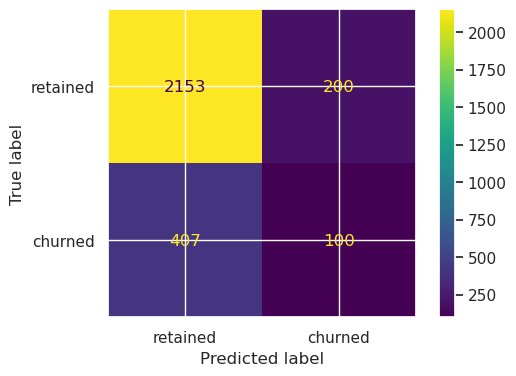

In [116]:
# Generate array of values for confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb_test, labels=xgb_gscv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['retained', 'churned'])

fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, values_format='d')
plt.show()

The model predicted two times as many false negatives than it did false positives, and it correctly identified only 19.7% of the users who actually churned.

#### **Feature Importance**

XGBoost made better use of the features than the Logistic Regression Model.  
The Engineered Features made up 6 of the top 10 features and 3 of the top 5.  

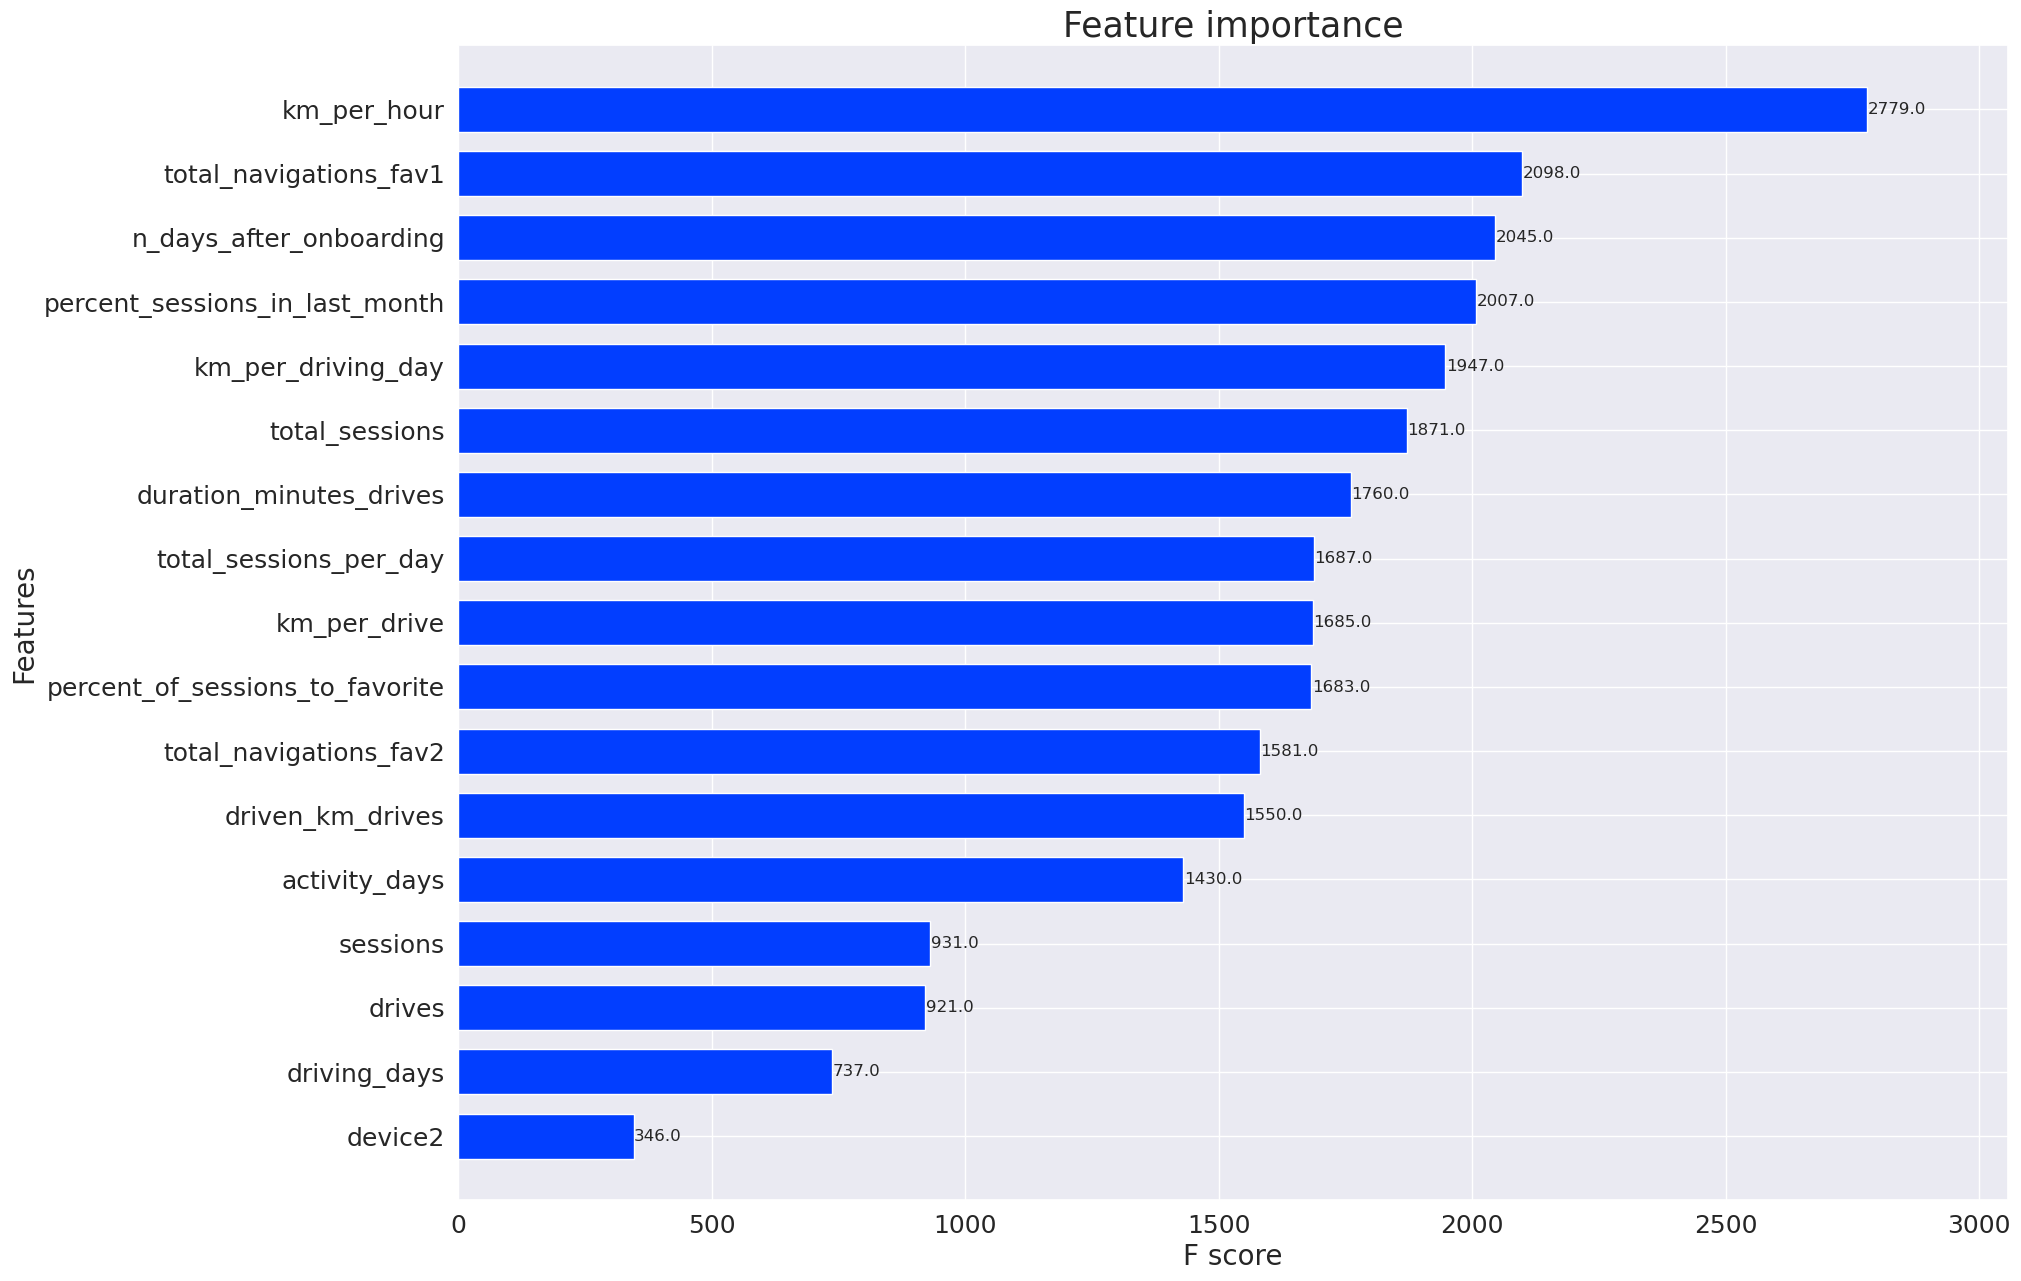

In [117]:
fig, ax = plt.subplots(figsize=(20,15))
plot_importance(xgb_gscv.best_estimator_, ax=ax, height=0.7)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Feature importance", fontsize=25)
plt.xlabel("F score", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.show()

### Optimal Decision Threshold for Precision-Recall Curve



#### Precision-Recall Curve

We can see that as recall increases, precision decreases.

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

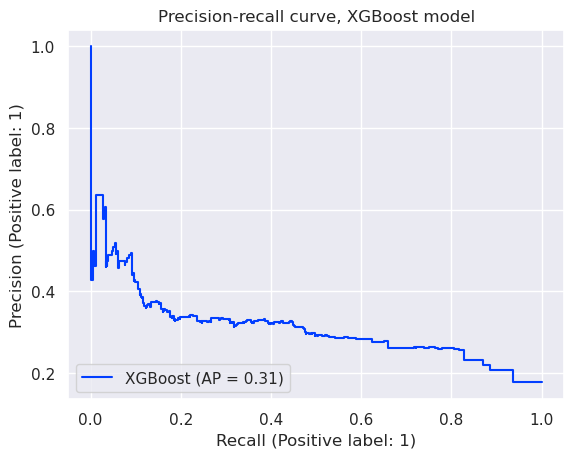

In [120]:
# Plot precision-recall curve
prec_recall_disp = PrecisionRecallDisplay.from_estimator(xgb_gscv.best_estimator_, X_test, y_test, name='XGBoost')
plt.title('Precision-recall curve, XGBoost model')
plt.show()

#### Predicted Probs

In [121]:
# Get predicted probabilities on the test data
pred_probs = xgb_gscv.best_estimator_.predict_proba(X_test)

/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/rsbaher/anaconda3/envs/intro/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

#### Prob Threshold of 0.4

We will generate new predictions based on a threshold of 0.4.  
ie. any value ≥ 0.4 in the second column will get a `1`, otherwise, `0`.

In [123]:
# Create a list of just the second column values (probability of target)
pred_probs_target = [x[1] for x in pred_probs]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in pred_probs_target])

In [124]:
# Get evaluation metrics for when the threshold is 0.4
thresh_metrics = get_test_scores("XGB 0.4 Threshold", new_preds, y_test)
thresh_metrics

Model  Accuracy  Precision  Recall        F1
0  XGB 0.4 Threshold  0.177273   0.177273     1.0  0.301158

Comparing these with the results from earlier:


In [125]:
final_res

Model  Accuracy  Precision    Recall        F1
0       Best Random Forest  0.818603   0.461719  0.135526  0.209230
0             Best XGBoost  0.795436   0.366889  0.211418  0.267899
0       Best RF Validation  0.913287   0.988679  0.516765  0.678756
0  Best XGBoost Validation  0.858392   0.666667  0.402367  0.501845
0        Best XGBoost Test  0.787762   0.333333  0.197239  0.247831


- Recall and F1 score increased.
- precision and accuracy decreased.

### Conclusion



Now that you've built and tested your machine learning models, the next step is to share your findings with the Waze leadership team. Consider the following questions as you prepare to write your executive summary. Think about key points you may want to share with the team, and what information is most relevant to the user churn project.

**Questions:**

1. Would you recommend using this model for churn prediction? Why or why not?

2. What tradeoff was made by splitting the data into training, validation, and test sets as opposed to just training and test sets?

3. What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?

4. What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?

5. What could you do to improve this model?

6. What additional features would you like to have to help improve the model?

1. No, because the Recall score is so low. It is not high enough to confidently predict users that churn.
2. Less data is used during training and since there is a class imbalance the model probably didnt see enough churned users
3. They are easier to interpret
4. less variation, less time preprocessing data
5. Engineer more data and collect more churned user data. Train model on more that just one month, maybe there is a trend in detecting churned users thats detectible over a few months.